In [1]:
import pandas as pd
import numpy as np
import warnings; 
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
#from sklearn.preprocessing import CategoricalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier

#note: should probably make attorney binary numeric--want one 0 1 feature, not a yes feature and a no features

## Creating Test/Train Sets

In [6]:
# this is to toggle the 2 (asylum: full, any) x 2 (predictability: early, late) models we may have

flag_full = 1
flag_early = 1

if flag_early:
    predtext = 'early'
else:
    predtext = 'late'
    
if flag_full:
    asylumtext = 'full'
else:
    asylumtext = 'any'

In [7]:
# loading appropriate files
path = '/data/WorkData/spatialtemporal/'
file = pd.read_csv(path + 'merged_last_hearing.csv')
timefile = pd.read_csv(path + 'gr_lastyear_' + predtext + '.csv')
test_cases = pd.read_csv(path + 'test_cases_last_hearing.csv', header=None)

In [8]:
timefile.dtypes

idnproceeding                       float64
idncase                             float64
nat_num_last1yr_early               float64
nat_gr_last1yr_early                float64
nat_dmy_last1yr_early               float64
tracid_num_last1yr_early            float64
tracid_gr_last1yr_early             float64
tracid_dmy_last1yr_early            float64
base_city_code_num_last1yr_early    float64
base_city_code_gr_last1yr_early     float64
base_city_code_dmy_last1yr_early    float64
dtype: object

In [5]:
# merge files
mergedfile = pd.merge(file, timefile, on=['idnproceeding','idncase'], how='left')

In [60]:
# get training data set
test_cases = test_cases.rename(columns={0:'num'})
train = mergedfile[~mergedfile.idncase.isin(test_cases.num)]

In [64]:
if flag_early:
    cols = ['idncase', 'idnproceeding','numAppsPerProc','dec_code','adj_date','osc_date','comp_date',
            'notice_desc','adj_time_start2','adj_time_stop2','durationHearing','averageHearingDur',
            'hearingDayOfWeek', 
            'caseDuration','numProcPerCase','numHearingsPerProc','durationFirstLastHearing','hearingYear',
            'hearingMonth','sched_type','adj_medium','adj_rsn_desc']
else:
    cols = ['idncase', 'idnproceeding','numAppsPerProc','dec_code','adj_date','osc_date','comp_date',
            'notice_desc','adj_time_start2','adj_time_stop2','durationHearing','averageHearingDur',
            'hearingDayOfWeek','tracid_num_last1yr_late.1']

class Cleaning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.drop(columns=cols)
            
        #X.loc[(X["dec"] == 'DENY'),'dec'] = 0
        #X.loc[(X["dec"] == 'GRANT'),'dec'] = 1
        #X['comp_date'] = pd.to_datetime(X['comp_date'],infer_datetime_format = True)
        #startdate = np.datetime64('1984-07-11')
        #X['comp_date_in_days'] = X['comp_date'].apply(lambda x: (x - startdate).days)
        #X = X.drop(columns=['comp_date'], axis=1)
        return X
    

In [65]:
clean = Cleaning()
train_data = clean.transform(train)

In [66]:
y_train = train_data['dec']
X_train = train_data.drop(columns=['dec'], axis=1)

In [67]:
# WHY DO WE DO THIS?Å
X_train.sched_type.unique()

AttributeError: 'DataFrame' object has no attribute 'sched_type'

## Generating Pipeline

In [68]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        num_frame = X.select_dtypes(include=[self.dtype])
        self.names = num_frame.columns
        return num_frame
    def get_feature_names(self):
        return self.names.tolist()

In [69]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #X = np.asarray(pd.get_dummies(X))
        #self.names = X.columns 
        self.names = np.array(0)
        self.orig_classes = np.array(0)
        for col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            #cat_frame = X.apply(le.fit_transform)
            self.names = np.append(self.names, le.classes_)
            c_list = np.array(0)
            for f in le.classes_:
                c_list = np.append(c_list,col)
            c_list = c_list[1:]
            self.orig_classes = np.append(self.orig_classes, c_list)
        self.names = self.names[1:]
        self.orig_classes =  self.orig_classes[1:]
    
        return X
    def get_feature_names(self):
        return self.names.tolist()
    def get_orig_classes(self): 
        # returns original variable type of the feature, i.e. nat
        return self.orig_classes.tolist()

In [79]:
# ===== DELETE THIS CELL ONCE LOADING FILES ARE UPDATED!! =====

# changing variables to appropriate types
# was erroring before. ASPEN: put into cleaning pipeline
 
    
# strings
X_train['nat'] = X_train['nat'].astype('str')
X_train['case_type'] = X_train['case_type'].astype('str')
X_train['c_asy_type'] = X_train['c_asy_type'].astype('str')
X_train['base_city_code'] = X_train['base_city_code'].astype('str')
X_train['hearing_loc_code'] = X_train['hearing_loc_code'].astype('str')
X_train['hearing_city'] = X_train['hearing_city'].astype('str')
X_train['base_city'] = X_train['base_city'].astype('str')
X_train['lang_hearing'] = X_train['lang_hearing'].astype('str')
X_train['pres_aff'] = X_train['pres_aff'].astype('str')

if not flag_early:
    X_train['adj_medium'] = X_train['adj_medium'].astype('str')
    X_train['sched_type'] = X_train['sched_type'].astype('str')
    X_train['caseDuration'] = X_train['caseDuration'].astype('float64')
    X_train['numProcPerCase'] = X_train['numProcPerCase'].astype('float64')
    X_train['numHearingsPerProc'] = X_train['numHearingsPerProc'].astype('float64')
    X_train['durationFirstLastHearing'] = X_train['durationFirstLastHearing'].astype('float64')
    X_train['hearingMonth'] = X_train['hearingMonth'].astype('float64')
    X_train['hearingYear'] = X_train['hearingYear'].astype('float64')


In [71]:
num_pipeline = Pipeline([
        ('selector', Selector(np.number)),
        ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
        ('selector', Selector('object')),
        ('labeler', CustomLabelEncoder())
        #('encoder', OneHotEncoder()),
]) 

full_pipeline = FeatureUnion(transformer_list=[ 
        ('numerical', num_pipeline),  
        ('categorical', cat_pipeline)   
])  

In [72]:
cat_pipeline_reg = Pipeline([
        ('selector', Selector('object')),
        ('labeler', CustomLabelEncoder()),
        ('encoder', OneHotEncoder())
]) 

full_pipeline_reg = FeatureUnion(transformer_list=[ 
        ('numerical', num_pipeline),  
        ('categorical', cat_pipeline_reg)   
])  

## Pipeline-for regression models
### (categorical variables one hot encoded)

In [18]:

#X_train = X_train[['nat','case_type','c_asy_type','base_city_code','hearing_loc_code']]
#X_train.head(5)

In [80]:
X_train_tr_reg = full_pipeline_reg.fit_transform(X_train)

## Hyperparameter Grid Search On Logistic Regression

In [81]:
c_vec = 10**np.arange(-3,5).astype('float64')
param_grid = {'penalty': ['l1','l2'], 'C': c_vec}

In [82]:
log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
#simplified for testing/writing code
#grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1,penalty = 'l1')

grid_search.fit(X_train_tr_reg, y_train)
result = pd.DataFrame(grid_search.cv_results_)

In [83]:
print(result)

    mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       15.844636         0.045373         0.681483          0.750957   0.001   
1        7.829264         0.044171         0.664485          0.760448   0.001   
2       57.288725         0.051625         0.654665          0.762684    0.01   
3       16.793991         0.048411         0.648542          0.765589    0.01   
4      165.350966         0.042591         0.644581          0.766633     0.1   
5       35.167538         0.051095         0.643981          0.767210     0.1   
6      267.230272         0.041521         0.643409          0.767496       1   
7       73.661618         0.054070         0.643375          0.767522       1   
8      208.500463         0.042602         0.643345          0.767628      10   
9      135.088985         0.046818         0.643400          0.767623      10   
10     116.338254         0.042226         0.643202          0.767616     100   
11     200.225213         0.

In [86]:
final_model = grid_search.best_estimator_
feature_weight = np.abs(grid_search.best_estimator_.coef_[0])

([<matplotlib.axis.YTick at 0x7f46f3687048>,
 <a list of 20 Text yticklabel objects>)

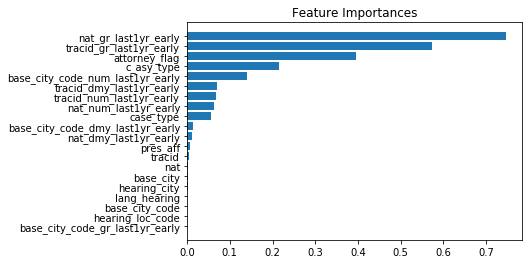

In [87]:
# simplify feature weights--sum together all weights for a given category (all nationalities)

num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline_reg.named_steps['labeler'].get_feature_names()
cat_classes = cat_pipeline_reg.named_steps['labeler'].get_orig_classes()
attributes = np.append(num_features,pd.unique(cat_classes)) 
attributes_long = num_features + cat_classes #for each of >1000 feature, lists original feature name, i.e. nat or tracid
feature_weight_simple = np.zeros(len(attributes))
for i in range(len(attributes)):
    weights = feature_weight[[x == attributes[i] for x in attributes_long]]
    feature_weight_simple[i] = np.mean(weights)
    
indices = np.argsort(feature_weight_simple)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_simple[indices], align='center')
plt.yticks(range(len(indices)), [attributes[i] for i in indices])


## Evaluate on Test Set

In [ ]:
test = mergedfile[mergedfile.idncase.isin(test_cases.num)] #don't need this now
test_data = clean.transform(test)
y_test = test_data['dec']
X_test = test_data.drop(columns=['dec'], axis=1)
X_test_tr = full_pipeline.transform(X_test)

In [ ]:
#num_features = num_pipeline.named_steps['selector'].get_feature_names()
#cat_features = cat_pipeline.named_steps['labeler'].get_feature_names()

In [ ]:
print(final_model.score(X_test_tr, y_test))

## Hyperparameter Grid Search On Decision Tree

In [88]:
X_train_tr = full_pipeline.fit_transform(X_train)

In [89]:
param_grid_dt = {"max_depth": [10, 5, 3, 1, None],
        "max_features": randint(1, 20),
        "min_samples_leaf": randint(1, 20),
        "criterion": ["gini", "entropy"]}

In [90]:
dec_tree = DecisionTreeClassifier()
grid_search_dt = RandomizedSearchCV(dec_tree, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_dt.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search_dt.cv_results_)
print(result)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0       2.354762         0.065968         0.623568          0.839373   
1       6.058885         0.128149         0.482921          0.992855   
2       1.743527         0.083743         0.599375          0.747695   
3       8.080369         0.071348         0.595161          0.853013   
4       1.468466         0.067361         0.552303          0.612737   
5       1.480776         0.058937         0.646645          0.714874   
6       3.491362         0.061570         0.711854          0.805664   
7       6.554572         0.064179         0.598632          0.850842   
8       2.340130         0.053034         0.756172          0.780553   
9       2.193084         0.088294         0.692190          0.770113   

  param_criterion param_max_depth param_max_features param_min_samples_leaf  \
0         entropy              10                  5                     10   
1         entropy            None                

In [ ]:
final_model_dt = grid_search_dt.best_estimator_
print(final_model_dt.score(X_test_tr, y_test))

Text(0.5,0,'Relative Importance')

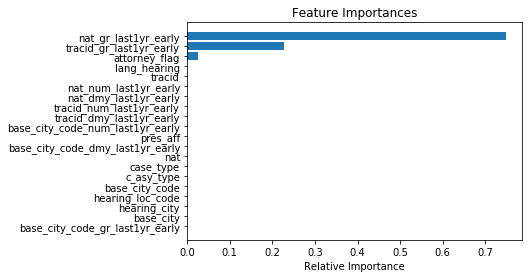

In [92]:
feature_weight_dt = grid_search_dt.best_estimator_.feature_importances_
num_features = num_pipeline.named_steps['selector'].get_feature_names()
cat_features = cat_pipeline.named_steps['selector'].get_feature_names()
attributes = num_features + cat_features
indices = np.argsort(feature_weight_dt)
ordered_attributes = [attributes[i] for i in indices]

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_weight_dt[indices], align='center')
plt.yticks(range(len(indices)), ordered_attributes)
plt.xlabel('Relative Importance')

## Hyperparameter Grid Search On Decision Tree

In [93]:
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_features': [2, 4, 6, 8, 10],
    'bootstrap': [False, True],
    'max_depth':[2, 4, 6, 8]
}

In [ ]:
rf = RandomForestClassifier()
grid_search_rf = RandomizedSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_tr, y_train)
result = pd.DataFrame(grid_search_rf.cv_results_)
print(result)

## Evaluate Random Forest Classifier on Test Set

In [ ]:
final_model_rf = grid_search_rf.best_estimator_
print(final_model_rf.score(X_test_tr, y_test))

In [ ]:
feature_weight_rf = grid_search_rf.best_estimator_.feature_importances_
indices_rf = np.argsort(feature_weight_rf)
ordered_attributes_rf = [attributes[i] for i in indices_rf]
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices_rf)), feature_weight_rf[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), ordered_attributes_rf)
plt.xlabel('Relative Importance')